In [1]:
#!jt -t chesterish -T -N -f roboto -fs 10
import numpy as np
import pandas as pd
import akshare as ak
from datetime import datetime as dt
from datetime import timedelta as td
import os
import re
from enum import Enum
from typing import List
from vnpy.trader.object import BarData
from vnpy.trader.constant import Direction, Offset, Exchange, Interval
import vnpy_sqlite.sqlite_database as sqlite
class source(Enum):
    SINA = 'sina'
    RQ = 'rq'

In [2]:
#func and constants
src = source.SINA
freq = '1'
reFetch:bool = True
d_format = "%Y-%m-%d %H:%M:%S"
pattern_letters_re = re.compile(r'[A-Za-z]')
pattern_number_re = re.compile(r'[0-9]')
#fut_contract_path = r'C:\Users\lingy\git-repo\xtt\quantresearch\dataset\future_contract_hist'
#fut_gen_hist_path = r'C:\Users\lingy\git-repo\xtt\quantresearch\dataset\future_generic_hist'
#fut_info_path = r'C:\Users\lingy\git-repo\xtt\quantresearch\dataset\future_base_info\rq\futures_info_details.csv'
fut_contract_path = r'E:\dataset\future_contract_hist'
fut_info_path = r'E:\dataset\future_base_info\rq\futures_info_details.csv'

def fetch_contract_history(ticker:str, exch:str,\
                           freq:str = '1',\
                           src: source = source.SINA,\
                           refetch: bool = False,\
                           base_path:str = './/dataset//future_contract_hist'):
    ticker_alias = ticker
    if exch == Exchange.CZCE.value:
        ticker_alias = pattern_number_re.sub('',ticker).upper() + '2'+ pattern_letters_re.sub('',ticker)
    filePath = os.path.join(base_path, src.value, freq, ticker_alias + '.csv')
    ticker_pd = pd.DataFrame()
    if refetch: #only refetch from sina
        ticker_pd = ak.futures_zh_minute_sina(symbol=ticker_alias, period=freq)
    else:
        ticker_pd = pd.read_csv(filePath)
    #augment df to fit vn bar object
    if src ==source.SINA:
        ticker_pd['order_book_id']=ticker
    #shift 1min back to fit vn convention
    ticker_pd['datetime'] = ticker_pd['datetime']\
    .apply(lambda r: dt.strftime(dt.strptime(r,d_format) - td(minutes = 1), d_format))
    ticker_pd['exchange'] = exch
    ticker_pd['gateway'] = src.value
    return ticker_pd
    
def push_db(bars:List[BarData]):
    sql_db = sqlite.SqliteDatabase()
    pushed = sql_db.save_bar_data(bars)
    closed = sql_db.db.close()
    return pushed,closed
def parseBar(row):
    return BarData(symbol = row['order_book_id'],\
                   exchange = Exchange(row['exchange']),\
                   datetime = dt.strptime(row['datetime'],d_format),\
                  volume = float(row['volume']),\
                  open_price = float(row['open']),\
                  high_price = float(row['high']),\
                  low_price = float(row['low']),\
                  close_price = float(row['close']),\
                  interval = Interval.MINUTE,\
                  gateway_name = row['gateway'])

In [4]:
#read 1m history and load db
ticker = 'ag2206'
exch = 'SHFE'
ticker_df = fetch_contract_history(ticker,exch,freq,src,reFetch,base_path = fut_contract_path)
bars = ticker_df.apply(parseBar,axis = 1).to_list()
s,c = push_db(bars)
print("ticker {0} loaded to db:{1}; Count {2}; db closed:{3}".format(ticker,s,len(bars),c))

ticker ag2206 loaded to db:True; Count 1023; db closed:True


In [7]:
#read 1m history and load db
ticker = 'fu2209'
exch = 'SHFE'
ticker_df = fetch_contract_history(ticker,exch,freq,src,reFetch,base_path = fut_contract_path)
bars = ticker_df.apply(parseBar,axis = 1).to_list()
s,c = push_db(bars)
print("ticker {0} loaded to db:{1}; Count {2}; db closed:{3}".format(ticker,s,len(bars),c))

ticker fu2209 loaded to db:True; Count 1023; db closed:True


In [8]:
#read 1m history and load db
ticker = 'FG209'
exch = 'CZCE'
ticker_df = fetch_contract_history(ticker,exch,freq,src,reFetch,base_path = fut_contract_path)
bars = ticker_df.apply(parseBar,axis = 1).to_list()
s,c = push_db(bars)
print("ticker {0} loaded to db:{1}; Count {2}; db closed:{3}".format(ticker,s,len(bars),c))

ticker FG209 loaded to db:True; Count 1023; db closed:True


In [9]:
#read 1m history and load db
ticker = 'hc2205'
exch = 'SHFE'
ticker_df = fetch_contract_history(ticker,exch,freq,src,reFetch,base_path = fut_contract_path)
bars = ticker_df.apply(parseBar,axis = 1).to_list()
s,c = push_db(bars)
print("ticker {0} loaded to db:{1}; Count {2}; db closed:{3}".format(ticker,s,len(bars),c))

ticker hc2205 loaded to db:True; Count 1023; db closed:True


In [10]:
#read 1m history and load db
ticker = 'v2205'
exch = 'DCE'
ticker_df = fetch_contract_history(ticker,exch,freq,src,reFetch,base_path = fut_contract_path)
bars = ticker_df.apply(parseBar,axis = 1).to_list()
s,c = push_db(bars)
print("ticker {0} loaded to db:{1}; Count {2}; db closed:{3}".format(ticker,s,len(bars),c))

ticker v2205 loaded to db:True; Count 1023; db closed:True


In [ ]:
#check db load
ticker = 'FG209'
exch = 'CZCE'
end_date = dt.now()
days_delta = 20
start_date = end_date - td(days = days_delta)
sql_db = sqlite.SqliteDatabase()
bar_dt_load = sql_db.load_bar_data(symbol = ticker, exchange = Exchange(exch), interval = Interval.MINUTE, start = start_date, end = end_date)
print("ticker check: {0} (last {1} days)".format(len(bar_dt_load),days_delta))
sql_db.db.close()

<AxesSubplot:>

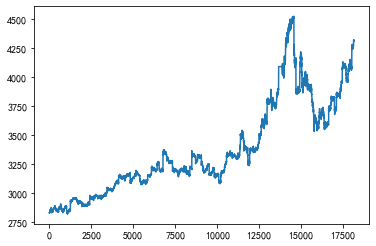

In [12]:
#data quick check
ticker_df['datetime']=ticker_df['datetime'].apply(lambda d:dt.strptime(d,d_format))
ticker_df['close'].plot()

In [30]:
bar_dt_load

[BarData(gateway_name='DB', symbol='FG209', exchange=<Exchange.CZCE: 'CZCE'>, datetime=datetime.datetime(2022, 3, 29, 9, 12, tzinfo=<DstTzInfo 'Asia/Shanghai' CST+8:00:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=647.0, turnover=0.0, open_interest=0.0, open_price=2046.0, high_price=2049.0, low_price=2046.0, close_price=2048.0),
 BarData(gateway_name='DB', symbol='FG209', exchange=<Exchange.CZCE: 'CZCE'>, datetime=datetime.datetime(2022, 3, 29, 9, 13, tzinfo=<DstTzInfo 'Asia/Shanghai' CST+8:00:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=2573.0, turnover=0.0, open_interest=0.0, open_price=2048.0, high_price=2053.0, low_price=2048.0, close_price=2053.0),
 BarData(gateway_name='DB', symbol='FG209', exchange=<Exchange.CZCE: 'CZCE'>, datetime=datetime.datetime(2022, 3, 29, 9, 14, tzinfo=<DstTzInfo 'Asia/Shanghai' CST+8:00:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=2260.0, turnover=0.0, open_interest=0.0, open_price=2053.0, high_price=2054.0, low_price=2052.0, close_price